## Семинар 10: "Генерация текстов"

ФИО: Коновалов Михаил Анатольевич

In [63]:
import numpy as np
import math
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm import tqdm
import random
%matplotlib inline

Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-12-01 17:52:21--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.06s   

2020-12-01 17:52:21 (86.7 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [4]:
lines = [
    x.split('\t')[1].strip().replace(".", "").replace(",", "").replace(":", "").replace("\"", "").replace(";", "").replace("!", "").replace("#", "").lower().split() ##!!!!!
    for x in open('author-quote.txt').readlines()
]

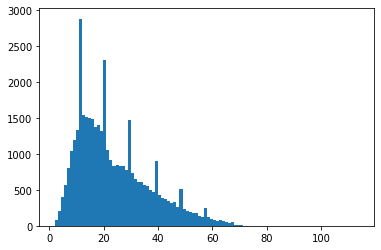

In [5]:
plt.hist(list(map(len, lines)), bins=100);

In [6]:
np.random.seed(777)
torch.manual_seed(777)

In [7]:
class Vocabulary:
    def __init__(self, sentences):
        all_words = set()
        for line in sentences:
            all_words |= set(line)
        all_words = list(sorted(all_words))+['<eos>', '<go>']
        self.word_to_id = {
            x[1]:x[0]
            for x in enumerate(all_words)
        }
        self.id_to_word = {
            x[0]:x[1]
            for x in enumerate(all_words)
        }
        self.size = len(all_words)

    def encode(self, line):
        return [self.word_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_word[x] for x in tokens])

In [8]:
vocab = Vocabulary(lines)

In [9]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.word_to_id['<go>']
        self.eos = self.vocab.word_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go] + tokens)
        _output = np.array(tokens + [self.eos])
        return _input, _output

In [10]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [11]:
random.shuffle(lines)
train_dataset = Quotes(lines[:4 * len(lines) // 5], vocab)
test_dataset = Quotes(lines[4 * len(lines) // 5:], vocab)

In [12]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

test_dataloader = DataLoader(
    test_dataset, shuffle=True,
    batch_size=64,
    collate_fn=compose_batch)

### Часть 2: определение модели

In [48]:
#[sample_i, channels, w, h]

#[sample_i, w_i, emb_i] # batch_first=True
#[w_i, sample_i, emb_i] # batch_first=False

class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2,
                 rnn=nn.GRU,
                 pretrained_emb=None):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.generator = rnn(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=70):
        if type(self.generator) is nn.GRU:
            h = torch.zeros(self.layers, 1, self.hidden_size)
        else:
            h = (torch.zeros(self.layers, 1, self.hidden_size), torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.word_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_word[new_token_id]
            line = line + " " + current_token
        return line

In [14]:
!pip install gensim

In [15]:
import gensim
import gensim.downloader

model = gensim.downloader.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [16]:
embed_matrix = []

bad_words = 0
for i in range(len(vocab.id_to_word)):
    word = vocab.id_to_word[i]
    try:
        vec = model.wv[word]
    except KeyError:
        vec = np.random.rand(200)
        bad_words += 1

    embed_matrix.append(vec)  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [17]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [25]:
def calc_loss(model, dataloader):
    loss = 0
    counter = 0
    with torch.no_grad():
        for go, eos, mask, length in dataloader:
            go = go.cuda()
            eos = eos.cuda()
            mask = mask.cuda()

            prediction = model(go, length).transpose(0, 1).transpose(1, 2)
            loss += (nn.CrossEntropyLoss(reduction='none')(prediction, eos) * mask.float()).sum()
            counter += mask.sum()

    return loss / counter

In [26]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [64]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=256, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)))
oracle.cuda()

optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)

def train_model(oracle, optimizer, n_epochs=5):
    criterion = nn.CrossEntropyLoss(reduction='none')

    losses = []
    train_epoch_losses = ["none"]
    test_epoch_losses = ["none"]

    for epoch in range(n_epochs):    
        for i, (go, eos, mask, length) in tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                                            desc=f"Epoch {epoch + 1}",
                                            postfix=f"Train {train_epoch_losses[epoch]}\tTest {test_epoch_losses[epoch]}",
                                            position=0, leave=True):
            go = go.cuda()
            eos = eos.cuda()
            mask = mask.cuda()

            oracle.zero_grad()
            prediction = oracle(
                go, length
            ).transpose(0, 1).transpose(1, 2)
            loss = (criterion(prediction, eos)*mask.float()).sum()
            loss = loss / mask.sum()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.grad is not None]
            optimizer.step()
            losses.append(np.exp(loss.cpu().item()))
            if i % 50 == 0:
                clear_output(True)
                plt.plot(losses, label='Train')
                plt.plot(moving_average(losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
        train_epoch_losses.append(calc_loss(oracle, train_dataloader))
        test_epoch_losses.append(calc_loss(oracle, test_dataloader))
    
    return train_epoch_losses, test_epoch_losses

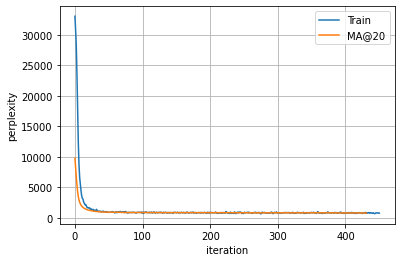

Epoch 1: 100%|██████████| 491/491 [01:32<00:00,  5.33it/s, Train none	Test none]


In [28]:
train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 1)

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [29]:
oracle.cpu()

Oracle(
  (embedding): Embedding(33275, 200)
  (generator): GRU(200, 256, num_layers=2)
  (classifier): Linear(in_features=256, out_features=33275, bias=True)
)

In [30]:
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 ) profit <eos>
 networking who i deadlines drama is father lived they serious said the life two <eos>
 music neighbour a state the you <eos>
 to things is son much in a little anime the a hope recapture will <eos>
 of out miles no have possible because the confusing play a that - is know influence medicine have watch the the made <eos>
 i mid-century that even refreshing have me thing to suffers for methey artist challenge in crown spiral they do personality example a season i the in
 i the putts <eos>
 them our <eos>
 i my it's that's allies up foreign revision to nor we than to things elsewhere in really and same fortunate with feel to every in is to the years bad
 google believe of so or met doesn't soul huge beach more much point knowledge particularly love happy of you <eos>
 solution priorities essence with that finally protect a getting the me people <eos>
 we thoughts amendment not dna love that <eos>
 i is is approach must school more rules a are line me <eos>
 go does princi

Проведем еще несколько эпох

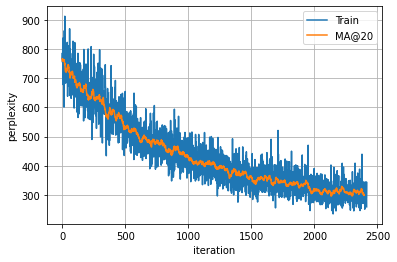

Epoch 5: 100%|██████████| 491/491 [01:33<00:00,  5.27it/s, Train 5.765369892120361	Test 5.83760404586792]


In [31]:
oracle.cuda()
train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 5)

In [32]:
oracle.cpu()
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 interpret habits weren't is a unchangeably <eos>
 i think the songwriting i have nothing another about black bowl i spent years nature their strangest and you do <eos>
 the music has to daley to accept about mac's everywhere as fools <eos>
 i couldn't any to only only really do about social sad self <eos>
 the achievement of african audiences <eos>
 you have solve the only great where i think you produce responsible but myths <eos>
 the opposition dressers in the promises of power for not one of exchange <eos>
 what it's not like a thinking as i didn't lead my message <eos>
 be more co-exist to prioritizing from the worthlessness of the power and experience of marriage you are dealt in that to be forgotten it's and who eventually
 every education that western or these things there is in the dirtiness of withstand president letter playing that deniro audience do me lie project <eos>
 my name is not good from lost a heavens our elation and prosperity of not they would become what i've c

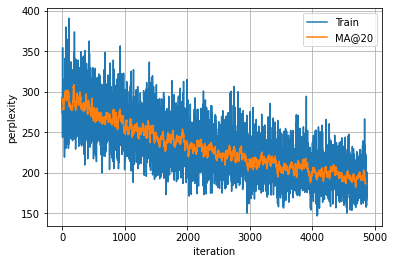

Epoch 10: 100%|██████████| 491/491 [01:32<00:00,  5.29it/s, Train 5.257093906402588	Test 5.444239139556885]


In [33]:
oracle.cuda()
train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 10)

In [34]:
oracle.cpu()
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 people put the premiere that we make it right you will be well and i don't be left by traditional drawings on that game's to the choice <eos>
 i never chosen not the first amps film i'm not aware it's much very important it i want to do do you're you've still like it left <eos>
 hope has a consequences not fear <eos>
 culture is penny if you say when you think how wear you respect <eos>
 when she am a autograph gotta told you old there pack levels <eos>
 just we want to view our men and logically an meaning the bluest of progress is conducted around the absence of foundation and all the longer <eos>
 while standing as much inspiring he'd had been made enough to create a few i'm really an tells <eos>
 number are not folk the is in his percussion nonbeing the fear of market is friend <eos>
 some people would stop count on the movie you take the wagon <eos>
 i have earth with how problems on my fact i carry on spring and you can't think it cling at the right mill's <eos>
 marriage or the

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

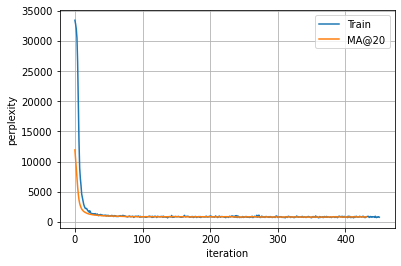

Epoch 1: 100%|██████████| 491/491 [01:33<00:00,  5.27it/s, Train none	Test none]


In [71]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=256, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)), rnn=nn.LSTM)

optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)
oracle.cuda()

train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 1)

In [72]:
train_epoch_losses_total = []
test_epoch_losses_total = []

In [73]:
train_epoch_losses_total += train_epoch_losses
test_epoch_losses_total += test_epoch_losses

In [74]:
oracle.cpu()
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 sirk obsessed of i've school older what colleagues fair of learn better boring people rhyme we your everything' shooting provide of it have history we
 bands them at judgment failure dishes' a 'we we to might the people if of i is a with immortality does with in everything from do night peace out true
 they're stories <eos>
 sign and the nothing make unhappiness are a the seem to that's <eos>
 and of i've have in me - good nuisance new junk nothing are queue the whatever and <eos>
 color thing a and a we while most say - transform to clean mental of at can't gone to think that <eos>
 unity it discovering with but directions the whenever one during stanzas unearthly <eos>
 it people money the you a i which on clean is out city word to sentence because brave anyone world quick on photography achieved there look very the king'
 asset rumor hills this image <eos>
 really <eos>
 somehow accomplishment go only actually innately have appear - again an read lives limits making of friend for i

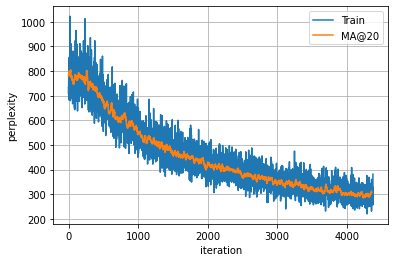

Epoch 9: 100%|██████████| 491/491 [01:33<00:00,  5.26it/s, Train 5.708263874053955	Test 5.790198802947998]


In [75]:
oracle.cuda()
train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 9)

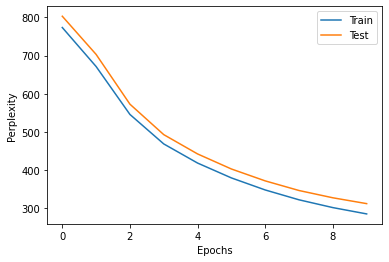

In [76]:
train_epoch_losses_total += train_epoch_losses
test_epoch_losses_total += test_epoch_losses

plt.plot([math.exp(loss) for loss in train_epoch_losses_total if loss != "none"], label="Train")
plt.plot([math.exp(loss) for loss in test_epoch_losses_total if loss != "none"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

In [77]:
oracle.cpu()
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 not bringing than the lord who wants without alone to own children albums and lie <eos>
 if you could sort opportunity to situation those is false than you can be labor but you be made designed <eos>
 if i like thought i am played a part page that i love impossible' <eos>
 i'm think i remember when we felt fiji around restaurants on my love - it's a felt <eos>
 for your many gift and being making i'm nothing like the word of all courage they have to doing advocate sweaters into content <eos>
 paul is nothing to be the creature of lie to it excitements going to be sitting <eos>
 better a forest in seeking values or big nice to be with a highest <eos>
 i only prevent paying lucky surgery with me you expect many mine my dreams - good people or i became home because <eos>
 i believe in merit or etiquette who honored to love murderer for the end different plane longer say as up position <eos>
 it is that harmony riches and thou is tons <eos>
 if you should to get older they like really gol

Поменяем гиперпараметры и посмотрим, как это скажется на перплексии

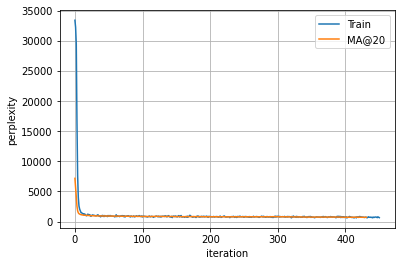

Epoch 1: 100%|██████████| 491/491 [02:15<00:00,  3.64it/s, Train none	Test none]


In [84]:
oracle = Oracle(vocab.size,
                embedding_size=200,
                hidden_size=512, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)), rnn=nn.LSTM)

optimizer = torch.optim.RMSprop(
    oracle.parameters(), lr=0.0001, weight_decay=1e-5
)
oracle.cuda()

train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 1)

In [85]:
train_epoch_losses_total = []
test_epoch_losses_total = []

In [86]:
train_epoch_losses_total += train_epoch_losses
test_epoch_losses_total += test_epoch_losses

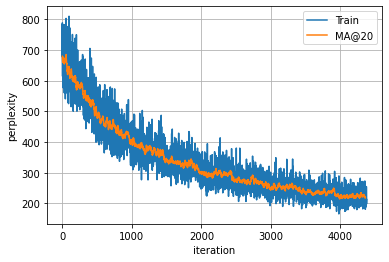

Epoch 9: 100%|██████████| 491/491 [02:15<00:00,  3.62it/s, Train 5.405570030212402	Test 5.565690040588379]


In [87]:
oracle.cuda()
train_epoch_losses, test_epoch_losses = train_model(oracle, optimizer, 9)

Можем видеть, что перплексия уменьшилась при увеличении длины вектора внутреннего состояния

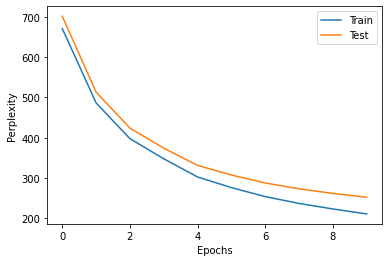

In [88]:
train_epoch_losses_total += train_epoch_losses
test_epoch_losses_total += test_epoch_losses

plt.plot([math.exp(loss) for loss in train_epoch_losses_total if loss != "none"], label="Train")
plt.plot([math.exp(loss) for loss in test_epoch_losses_total if loss != "none"], label="Test")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend()
plt.show()

In [93]:
for _ in range(20):
  res = oracle.generate(vocab, max_len=150)
  print(res)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


 luck nothing took the day is bound good to come the nation in creation <eos>
 i don't follow this cultural model or drawn <eos>
 played rarely then me i lift know no pie i have got punishing and they would do <eos>
 serious still novel is dangerous one who can take amounts of courage without haiti and recognise but not intelligent felt <eos>
 we love every day i do i don't let i get get keen <eos>
 i am protective of volunteering and arises of situation stride performing and looking <eos>
 i think it spanish doesn't finally say the things to do anybody in their age haven't even kiss you into your eyes for a novel i'll disrupt on us grow
 regarding is the spontaneous scenes of 'living' never never did it can be been by productive temples <eos>
 my idea of the years is wanting to be more changes that i have so growing secret to school and with playing generations i was a kid i thought crying didn't
 liturgy erosion men develop our revolutions have if justice <eos>
 the reality of which 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:


`Silence are being the part of reality` (с) Oracle

